## Figure 4. Learning cost gradient (fixed input $x$)

In [23]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
import pandas as pd
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML

from lib.lif import LIF, ParamsLIF

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda/miniconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['norm', 'rand', 'rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [24]:
q = 3              #Dimension of learnt vector
dt = 0.001         #Simulation timestep
DeltaT = 20        #Number of timebins over which learning rule is applied
tsim = 60            #Total simulation time
T = (tsim/dt)/DeltaT #Number of learning blocks
Nsims = 50               #Number of repeated simulations
c = 0.99           #Correlation coefficient
x = 0              #Input
n = 2              #Number of neurons
sigma = 10         #Their noise level
mu = 1             #Threshold
tau = 1            #Neuron timescale
eta = 0.5           #Learning rate
p = 0.05            #Learning window
tau_s = 0.20      #Output filter timescale

N = 19
wmax = 20
wmin = 2

nsims = 1
p = 0.05

fn_in = './sweeps/param_w_N_%d_nsims_%d_c_%f_deltaT_simulations.npz'%(N, nsims, c)
sims = np.load(fn_in)
hs = sims['hs']
vs = sims['vs']
wvals = sims['wvals']

t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

cost2 = np.zeros((N,N))
cost2_tmp = np.zeros((nsims,hs.shape[4]))

B1 = 1
B2 = 2
x = .01
y = 0.1
z = 0
cost_fun = lambda s1, s2: (B1*s1-x)**2 + (z+B2*s2 - B2*(B1*s1-y)**2)**2

w1 = 3
w2 = 7

In [25]:
params_lif = ParamsLIF(sigma = sigma, tau = tau, mu = mu, c = c)
lif = LIF(params_lif, t = tsim)
lif.W = np.array([w1, w2])
lif.x = 0

t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

## 4A. Learning progress over time for individual weights

In [ ]:
#Also collect the c_abv, c_below for p = 0.03, p = 1, accumulated over each epoch, and estimate 
#the 'true' beta as we go
c1_abv_p = np.zeros(0)
c1_abv_1 = np.zeros(0)
c1_blo_p = np.zeros(0)
c1_blo_1 = np.zeros(0)

c2_abv_p = np.zeros(0)
c2_abv_1 = np.zeros(0)
c2_blo_p = np.zeros(0)
c2_blo_1 = np.zeros(0)

beta_rd_true = np.zeros((n, T, Nsims))
beta_fd_true = np.zeros((n, T, Nsims))
beta_rd = np.zeros((n, T, Nsims))
beta_rd_mean = np.zeros((n, T, Nsims))

for idx in range(Nsims):
    count = np.zeros(n)
    print("N=%d"%idx)
    #Simulate LIF
    (v_raw, h_raw, _, _) = lif.simulate()
    s1 = np.convolve(h_raw[0,:], exp_filter)[0:h_raw.shape[1]]
    s2 = np.convolve(h_raw[1,:], exp_filter)[0:h_raw.shape[1]]
    
    V = np.zeros((n, q))
    V_mean = np.zeros((n, q))
    
    abvthr = np.zeros(n)
    blothr = np.zeros(n)
    
    cost_raw = cost_fun(s1, s2)
    #Break the simulation and voltage into blocks
    nB = h_raw.shape[1]/DeltaT
    hm = h_raw.reshape((n, nB, DeltaT))
    vm = v_raw.reshape((n, nB, DeltaT))
    #print nB
    #print DeltaT
    #print cost_raw.shape
    
    v = np.max(vm, 2)
    h = np.max(hm, 2)
    cost_r = cost_raw.reshape((nB, DeltaT))
    cost = np.squeeze(cost_r[:,-1])

    #Then just repeat the learning rule as before
    dV = np.zeros(V.shape)
    bt = [False, False]
    for t in range(nB):
        for k in range(n):
            if (v[k,t] < mu):
                if k == 0:
                    c1_blo_1 = np.hstack((c1_blo_1, cost[t]))
                else:
                    c2_blo_1 = np.hstack((c2_blo_1, cost[t]))
            if (v[k,t] >= mu):
                if k == 0:
                    c1_abv_1 = np.hstack((c1_abv_1, cost[t]))
                else:
                    c2_abv_1 = np.hstack((c2_abv_1, cost[t]))

            if (v[k,t] > mu - p) & (v[k,t] < mu):
                if k == 0:
                    c1_blo_p = np.hstack((c1_blo_p, cost[t]))
                else:
                    c2_blo_p = np.hstack((c2_blo_p, cost[t]))
                blothr[k] += 1
                if bt[k] == False:
                    ahat = np.array([1, 0, -(v[k,t]-mu)])
                    #ahat = np.array([1, 0, 0])
                    dV[k,:] += (np.dot(V[k,:], ahat)+cost[t])*ahat                    
                    bt[k] = True
            elif (v[k,t] < mu + p) & (v[k,t] >= mu):
                if k == 0:
                    c1_abv_p = np.hstack((c1_abv_p, cost[t]))
                else:
                    c2_abv_p = np.hstack((c2_abv_p, cost[t]))
                abvthr[k] += 1
                #Only do the update when firing...
                if bt[k] == True:
                    ahat = np.array([1, (v[k,t]-mu), 0])
                    #ahat = np.array([1, 0, 0])
                    dV[k,:] += (np.dot(V[k,:], ahat)-cost[t])*ahat                                        
                    count[k] += 1
                    V_mean[k,:] = (V_mean[k,:]*count[k] - dV[k,:])/(count[k]+1)
                    V[k,:] = V[k,:] - eta*dV[k,:]
                    dV[k,:] = np.zeros((1,q))
                    bt[k] = False
                
            beta_rd[k,t,idx] = V[k,0]
            beta_rd_mean[k,t,idx] = V_mean[k,0]
        beta_rd_true[0,t,idx] = np.mean(c1_abv_p)-np.mean(c1_blo_p)
        beta_rd_true[1,t,idx] = np.mean(c2_abv_p)-np.mean(c2_blo_p)
        beta_fd_true[0,t,idx] = np.mean(c1_abv_1)-np.mean(c1_blo_1)
        beta_fd_true[1,t,idx] = np.mean(c2_abv_1)-np.mean(c2_blo_1)

#Test how well we learnt beta through an extra second of simulation
print("N = %d. Unit 1. Above thr %d: Below thr: %d. Percent above: %2.2f"%(idx, abvthr[0], blothr[0], 100*float(abvthr[0])/(blothr[0]+abvthr[0])))
print("N = %d. Unit 2. Above thr %d: Below thr: %d. Percent above: %2.2f"%(idx, abvthr[1], blothr[1], 100*float(abvthr[1])/(blothr[1]+abvthr[1])))


/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


N=0


/opt/anaconda/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/opt/anaconda/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


N=1
N=2
N=3
N=4
N=5
N=6
N=7


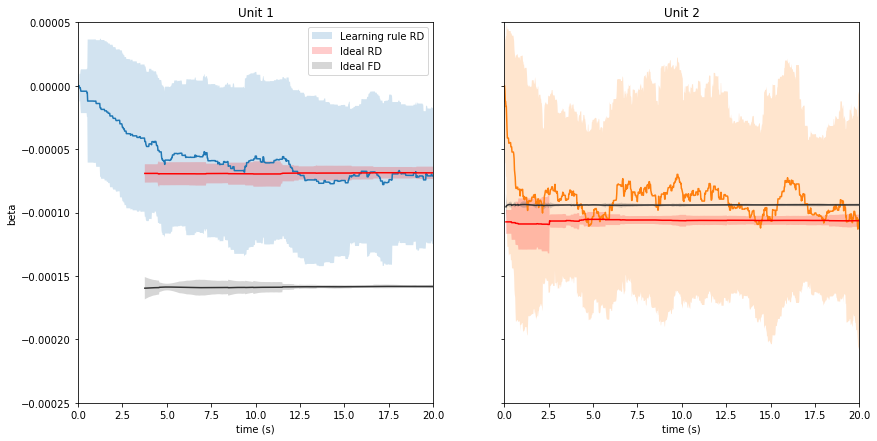

In [150]:
T = int(T)
ts = np.arange(T).astype(float)/T*tsim

fig,(ax1, ax2) = plt.subplots(1,2,figsize=(14,7), sharey = True)

sns.tsplot(data = 2.4*beta_rd[0,:,:].T, ax = ax1, ci = 'sd', time=ts, color='C0')
sns.tsplot(data = 2.4*beta_rd[1,:,:].T, ax = ax2, ci = 'sd', time=ts, color='C1')

#sns.tsplot(data = 2.4*beta_rd_mean[0,:,:].T, ax = ax1, ci = 'sd', time=ts, color='C0')
#sns.tsplot(data = 2.4*beta_rd_mean[1,:,:].T, ax = ax2, ci = 'sd', time=ts, color='C1')

sns.tsplot(data = beta_rd_true[0,:,:].T, ax = ax1, ci = 'sd', time=ts, color=(1, 0 ,0))
sns.tsplot(data = beta_rd_true[1,:,:].T, ax = ax2, ci = 'sd', time=ts, color=(1, 0 ,0))

sns.tsplot(data = beta_fd_true[0,:,:].T, ax = ax1, ci = 'sd', time=ts, color=(.2, .2 ,.2))
sns.tsplot(data = beta_fd_true[1,:,:].T, ax = ax2, ci = 'sd', time=ts, color=(.2, .2 ,.2))

ax1.set_xlim([0, 20])
ax2.set_xlim([0, 20])
ax1.set_xlabel('time (s)');
ax1.set_ylabel('beta');
ax1.set_ylim([-0.00025, 0.00005])
ax2.set_ylim([-0.00025, 0.00005])
ax2.set_xlabel('time (s)');
ax1.set_title("Unit 1")
ax2.set_title("Unit 2")
ax1.legend({'Learning rule RD', 'Ideal RD', 'Ideal FD'})
plt.savefig('./fig_4a.pdf')

## 4B, C Learning progress over time for a range of weights

In [4]:
#Estimate mean cost function from sims
for i in range(N):
    #print("W[0] = %d"%i)
    for j in range(N):
        for k in range(nsims):
            s1 = np.convolve(hs[i,j,k,0,:], exp_filter)[0:hs.shape[4]]
            s2 = np.convolve(hs[i,j,k,1,:], exp_filter)[0:hs.shape[4]]
            cost2_tmp[k,:] = cost_fun(s1, s2)
        cost2[i,j] = np.mean(cost2_tmp)

In [5]:
learnt_beta = np.load('./sweeps/learningbeta_maxv_fixedx_sweepw_banana_perturbation.npz')
beta_rd = learnt_beta['beta_rd']
beta_rd_mean = learnt_beta['beta_rd_mean']
beta_rd_true = learnt_beta['beta_rd_true']
beta_fd_true = learnt_beta['beta_fd_true']
beta_sp = learnt_beta['beta_sp']

In [6]:
mu1_w1 = array([[ 0.00038599,  0.00040598,  0.00039597,  0.00042193,  0.00036397,
         0.000488  ,  0.00042984,  0.00042002,  0.00043874,  0.00041903,
         0.00042666,  0.000456  ,  0.00036799,  0.00040069,  0.000388  ,
         0.00039414,  0.00048585,  0.00039574,  0.00041769],
       [ 0.00050005,  0.0005207 ,  0.00049005,  0.00051019,  0.00050673,
         0.00056246,  0.000505  ,  0.00049696,  0.0004818 ,  0.00053866,
         0.000508  ,  0.00051081,  0.00055979,  0.00047087,  0.00052298,
         0.00047997,  0.00049696,  0.000495  ,  0.00050546],
       [ 0.00068158,  0.00065558,  0.00062987,  0.00075025,  0.00069399,
         0.00068363,  0.00066428,  0.00069108,  0.00068236,  0.00070605,
         0.00069582,  0.0006529 ,  0.00068986,  0.00071986,  0.00070854,
         0.00068881,  0.00065902,  0.00069495,  0.00063837],
       [ 0.00084199,  0.00084161,  0.00080746,  0.00082982,  0.00083486,
         0.00080771,  0.00088978,  0.00091595,  0.00088368,  0.00079918,
         0.00083571,  0.00084361,  0.00087883,  0.00087306,  0.00084834,
         0.00089165,  0.00087076,  0.00086166,  0.00082482],
       [ 0.00101953,  0.00103083,  0.00098083,  0.00089556,  0.00098754,
         0.00091789,  0.00095904,  0.00089429,  0.00093192,  0.00089792,
         0.00087846,  0.00092458,  0.00098362,  0.00096864,  0.00098059,
         0.00095205,  0.00099718,  0.00093202,  0.00093931],
       [ 0.00111135,  0.00106748,  0.00114005,  0.00109796,  0.00106708,
         0.00103859,  0.00106712,  0.00108993,  0.00100918,  0.00112311,
         0.00107799,  0.00108532,  0.00099543,  0.00110689,  0.00109881,
         0.00106763,  0.00109919,  0.00109064,  0.00102853],
       [ 0.00118278,  0.00117647,  0.0012955 ,  0.0012525 ,  0.00118136,
         0.00123439,  0.00120861,  0.00137386,  0.00120989,  0.00128787,
         0.00133611,  0.00128664,  0.00123063,  0.0011746 ,  0.00125785,
         0.00121213,  0.00115176,  0.0012656 ,  0.00128238],
       [ 0.00133791,  0.00133278,  0.00134302,  0.00137175,  0.00135494,
         0.00135622,  0.00132922,  0.0011377 ,  0.00147214,  0.0012396 ,
         0.00132006,  0.00130101,  0.00131254,  0.00133562,  0.00122744,
         0.00130411,  0.00126878,  0.00128063,  0.00138525],
       [ 0.00142574,  0.00131628,  0.00127544,  0.00139871,  0.00136446,
         0.00135486,  0.00142257,  0.00130103,  0.0013225 ,  0.00140089,
         0.00136071,  0.00143726,  0.00130831,  0.0014774 ,  0.00138227,
         0.00143248,  0.00142286,  0.00136075,  0.00138667],
       [ 0.0014238 ,  0.00145456,  0.00138087,  0.00141743,  0.00140936,
         0.00142052,  0.00136963,  0.00153202,  0.00137771,  0.00143962,
         0.0015589 ,  0.00147152,  0.00146363,  0.00141913,  0.00146648,
         0.00139234,  0.00156631,  0.00151228,  0.00145267],
       [ 0.00148697,  0.00160463,  0.00166421,  0.00145639,  0.00160499,
         0.00151973,  0.00152333,  0.00156144,  0.00168855,  0.00150168,
         0.0014435 ,  0.00141151,  0.00149003,  0.00147737,  0.00154546,
         0.00155103,  0.00158634,  0.00158611,  0.00157017],
       [ 0.00151277,  0.00164954,  0.0017444 ,  0.00161395,  0.0017039 ,
         0.00162787,  0.00157896,  0.00173744,  0.00160001,  0.00169206,
         0.00155788,  0.00161477,  0.00153097,  0.00165782,  0.00173219,
         0.0017318 ,  0.00158837,  0.00155546,  0.0016032 ],
       [ 0.00171402,  0.00169213,  0.00165084,  0.00175836,  0.00169167,
         0.0018382 ,  0.00175515,  0.00172877,  0.00165181,  0.00183087,
         0.00169965,  0.00177343,  0.00183747,  0.00156226,  0.00162345,
         0.00164613,  0.0016256 ,  0.0016944 ,  0.00168483],
       [ 0.00182761,  0.00172024,  0.00174301,  0.0018124 ,  0.00179938,
         0.00177177,  0.00193176,  0.00169098,  0.00190236,  0.00165908,
         0.00175208,  0.00173567,  0.00189416,  0.0017855 ,  0.00166039,
         0.0017661 ,  0.00173364,  0.00178818,  0.00172257],
       [ 0.0017741 ,  0.00176305,  0.0017226 ,  0.00182671,  0.00190443,
         0.00165484,  0.00176612,  0.00177527,  0.0017661 ,  0.00171671,
         0.00172309,  0.00177123,  0.0018007 ,  0.00188633,  0.00176034,
         0.00177719,  0.00183588,  0.00175412,  0.00181269],
       [ 0.00193957,  0.00195359,  0.0019136 ,  0.00185922,  0.00162685,
         0.0016888 ,  0.00170052,  0.00183721,  0.0016231 ,  0.00202352,
         0.00191789,  0.00177132,  0.00171985,  0.00183247,  0.00175876,
         0.001748  ,  0.00180178,  0.00174888,  0.00179036],
       [ 0.00190472,  0.00168663,  0.00168883,  0.00173074,  0.00176623,
         0.00177844,  0.00182092,  0.00181515,  0.00179228,  0.00187271,
         0.00212044,  0.00182895,  0.00185274,  0.00188583,  0.00204558,
         0.00190887,  0.00174213,  0.0018658 ,  0.00184679],
       [ 0.0016832 ,  0.00168673,  0.00168828,  0.00168417,  0.00194335,
         0.00198359,  0.00206868,  0.00196766,  0.00196224,  0.00175316,
         0.00193861,  0.00192453,  0.00180256,  0.00170457,  0.00211544,
         0.00203783,  0.00203711,  0.00193599,  0.00195682],
       [ 0.00159163,  0.00219728,  0.00228925,  0.00183343,  0.00173962,
         0.00206308,  0.00221148,  0.00210991,  0.00209484,  0.00168756,
         0.00199206,  0.00188813,  0.00156082,  0.00166656,  0.0018655 ,
         0.00210739,  0.00239841,  0.00183418,  0.00179924]])

mu2_w2 = array([[ 0.000446  ,  0.0005415 ,  0.0006417 ,  0.00083065,  0.00097245,
         0.0010978 ,  0.0012355 ,  0.00133635,  0.0013682 ,  0.00148835,
         0.00156246,  0.00156137,  0.00168613,  0.00168277,  0.0018556 ,
         0.00179539,  0.00179137,  0.00203568,  0.00206687],
       [ 0.00043596,  0.00049673,  0.00069057,  0.00080389,  0.00098361,
         0.00115789,  0.00115075,  0.00133238,  0.00143531,  0.001472  ,
         0.00159692,  0.00149256,  0.00165679,  0.00178738,  0.0017362 ,
         0.0020496 ,  0.00191506,  0.00177167,  0.00196186],
       [ 0.00041986,  0.000486  ,  0.00068316,  0.00089213,  0.00095728,
         0.00101379,  0.00120099,  0.00127697,  0.00149165,  0.00150112,
         0.00144538,  0.00173069,  0.00156989,  0.00166823,  0.00189309,
         0.0017131 ,  0.00193331,  0.00199961,  0.00179394],
       [ 0.000444  ,  0.00047299,  0.00073453,  0.00087492,  0.00096004,
         0.00106757,  0.00112241,  0.00128519,  0.00145077,  0.00151128,
         0.00144796,  0.00160409,  0.00178974,  0.00179491,  0.00181646,
         0.00179908,  0.00171835,  0.00183679,  0.00196917],
       [ 0.00041169,  0.00050197,  0.0006853 ,  0.00081856,  0.00098908,
         0.0011578 ,  0.00122423,  0.00131625,  0.00133507,  0.0014267 ,
         0.00151246,  0.00177739,  0.00176151,  0.00162685,  0.00188322,
         0.00179539,  0.00186886,  0.00183257,  0.00157579],
       [ 0.000434  ,  0.000505  ,  0.00065568,  0.00079583,  0.00095114,
         0.00111918,  0.00113049,  0.00124464,  0.00148401,  0.00143109,
         0.00143035,  0.00165738,  0.00178069,  0.00183485,  0.00175708,
         0.00197527,  0.00194129,  0.00156736,  0.00156573],
       [ 0.00037823,  0.00050929,  0.00070817,  0.00084565,  0.00091968,
         0.00108503,  0.0013162 ,  0.00124512,  0.00137507,  0.00152976,
         0.00154014,  0.00163492,  0.00164746,  0.00178343,  0.00175251,
         0.00178416,  0.00195335,  0.00182687,  0.00168503],
       [ 0.00038137,  0.00053886,  0.0007249 ,  0.00078204,  0.00089724,
         0.00107317,  0.00132887,  0.00132812,  0.00130825,  0.00152633,
         0.00158447,  0.00162526,  0.00162231,  0.00175017,  0.00184612,
         0.00176055,  0.00191288,  0.00184918,  0.0016359 ],
       [ 0.0003761 ,  0.00053397,  0.00072272,  0.00084288,  0.00094256,
         0.00109982,  0.00110895,  0.0013349 ,  0.00145824,  0.00142183,
         0.00158015,  0.00162646,  0.00181125,  0.00162432,  0.00170776,
         0.00192503,  0.00179468,  0.00186126,  0.0019122 ],
       [ 0.0003573 ,  0.00051175,  0.00071724,  0.00080404,  0.00094574,
         0.00110788,  0.00125765,  0.00121976,  0.00140209,  0.0015708 ,
         0.00153471,  0.00148971,  0.00173317,  0.00200275,  0.00178751,
         0.00180897,  0.00176982,  0.00176937,  0.00191689],
       [ 0.00038677,  0.00049114,  0.00069791,  0.0008141 ,  0.00096087,
         0.00107936,  0.00118476,  0.00135833,  0.00134985,  0.00153053,
         0.0016002 ,  0.00154239,  0.00162691,  0.00178256,  0.00181936,
         0.0019133 ,  0.00195821,  0.00182943,  0.00189936],
       [ 0.000432  ,  0.00050391,  0.00067349,  0.00083413,  0.00092741,
         0.00107996,  0.00123994,  0.00134718,  0.00136844,  0.00137237,
         0.00151758,  0.00166076,  0.00176222,  0.00184476,  0.00177366,
         0.00174143,  0.00187844,  0.0019346 ,  0.00192381],
       [ 0.00044994,  0.00052491,  0.00067573,  0.00086132,  0.00098153,
         0.00097837,  0.00120021,  0.00137198,  0.00133821,  0.00158501,
         0.00162148,  0.00145352,  0.00171016,  0.00183002,  0.00179396,
         0.00188548,  0.00174247,  0.0017397 ,  0.00188315],
       [ 0.000448  ,  0.00053135,  0.00065414,  0.00081968,  0.00097696,
         0.00109869,  0.00128032,  0.00126901,  0.00141789,  0.00146589,
         0.00142841,  0.00165206,  0.00161428,  0.00169692,  0.0018397 ,
         0.00187314,  0.00200194,  0.00188295,  0.00170411],
       [ 0.00040306,  0.00053121,  0.00067292,  0.00083537,  0.0009783 ,
         0.00112677,  0.0011996 ,  0.00135955,  0.00138792,  0.00140203,
         0.0016294 ,  0.0015873 ,  0.00165929,  0.00170672,  0.00179171,
         0.00185181,  0.00172502,  0.00186881,  0.00204772],
       [ 0.00044198,  0.00049034,  0.0007102 ,  0.00087527,  0.00094613,
         0.00114307,  0.0012157 ,  0.00116656,  0.00140647,  0.00144578,
         0.00152039,  0.00172919,  0.00170201,  0.0017957 ,  0.00175672,
         0.00176954,  0.00191976,  0.00186692,  0.00176801],
       [ 0.00047699,  0.00053555,  0.00068346,  0.00076022,  0.00092561,
         0.00116263,  0.00115406,  0.00125679,  0.0015152 ,  0.00154293,
         0.00137315,  0.00151327,  0.0018694 ,  0.00170555,  0.00166573,
         0.00199867,  0.00186961,  0.00172195,  0.00180565],
       [ 0.000338  ,  0.00050141,  0.00071897,  0.00084259,  0.00095716,
         0.00106954,  0.00124009,  0.00130556,  0.00144191,  0.00149317,
         0.00144307,  0.00162601,  0.00174671,  0.00187147,  0.0018546 ,
         0.0016261 ,  0.00184165,  0.00195877,  0.00176293],
       [ 0.000444  ,  0.00048295,  0.00066826,  0.00083388,  0.00097642,
         0.00120885,  0.00118343,  0.00120643,  0.00141736,  0.00164332,
         0.0014615 ,  0.00137197,  0.00166524,  0.00188582,  0.0020317 ,
         0.00193719,  0.0016972 ,  0.00175184,  0.00199827]])

Make histograms of learnt relative error (in magnitude) and error in direction.

In [10]:
beta_sp.shape

(19, 19, 2, 3000, 4)

In [16]:
#beta_rd = learnt_beta['beta_rd']
#beta_rd_mean = learnt_beta['beta_rd_mean']
#beta_rd_true = learnt_beta['beta_rd_true']
#beta_fd_true = learnt_beta['beta_fd_true']
#beta_sp = learnt_beta['beta_sp']

grad = np.gradient(cost2)
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))
hada = np.multiply

div = 50

errors_rd = np.zeros((N,N,beta_rd.shape[3]/div))
errors_fd_true = np.zeros((N,N,beta_rd.shape[3]/div))
errors_rd_true = np.zeros((N,N,beta_rd.shape[3]/div))
errors_sp = np.zeros((N,N,beta_rd.shape[3]/div,beta_sp.shape[4]))

angles_rd = np.zeros(errors_rd.shape)

beta_est0sp = np.zeros((N, N, beta_sp.shape[4]))
beta_est1sp = np.zeros((N, N, beta_sp.shape[4]))

for ep in range(0,beta_rd.shape[3], div):
    i = ep/div
    beta_est0 = hada(mu1_w1, beta_rd[:,:,0,ep])/ds
    beta_est1 = hada(mu2_w2, beta_rd[:,:,1,ep])/ds

    beta_est0fdt = hada(mu1_w1, beta_fd_true[:,:,0,ep])/ds
    beta_est1fdt = hada(mu2_w2, beta_fd_true[:,:,1,ep])/ds
    
    beta_est0rdt = hada(mu1_w1, beta_rd_true[:,:,0,ep])/ds
    beta_est1rdt = hada(mu2_w2, beta_rd_true[:,:,1,ep])/ds

    for idx in range(beta_sp.shape[4]):
        beta_est0sp[:,:,idx] = hada(mu1_w1, beta_sp[:,:,0,ep,idx])/ds
        beta_est1sp[:,:,idx] = hada(mu2_w2, beta_sp[:,:,1,ep,idx])/ds

    norm = np.sqrt(grad[0]**2 + grad[1]**2)
    errors_rd[:,:,i] = np.divide(np.sqrt((beta_est0-grad[0])**2 + (beta_est1-grad[1])**2),norm)
    for idx in range(beta_sp.shape[4]):
        errors_sp[:,:,i,idx] = np.divide(np.sqrt((beta_est0sp[:,:,idx]-grad[0])**2 + (beta_est1sp[:,:,idx]-grad[1])**2),norm)
    errors_fd_true[:,:,i] = np.divide(np.sqrt((beta_est0fdt-grad[0])**2 + (beta_est1fdt-grad[1])**2),norm)
    errors_rd_true[:,:,i] = np.divide(np.sqrt((beta_est0rdt-grad[0])**2 + (beta_est1rdt-grad[1])**2),norm)

    angles_rd[:,:,i] = np.arctan(beta_est0-grad[0], beta_est1-grad[1])
    
errors_rd = errors_rd.reshape((-1,1,errors_rd.shape[2]));
errors_sp = errors_sp.reshape((-1,1,errors_sp.shape[2], errors_sp.shape[3]));
errors_rd_true = errors_rd_true.reshape((-1,1,errors_rd_true.shape[2]));
errors_fd_true = errors_fd_true.reshape((-1,1,errors_fd_true.shape[2]));

angles_rd = angles_rd.reshape((-1,1,errors_rd.shape[2]))

In [20]:
errors_sp.shape

(361, 1, 60, 4)

/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


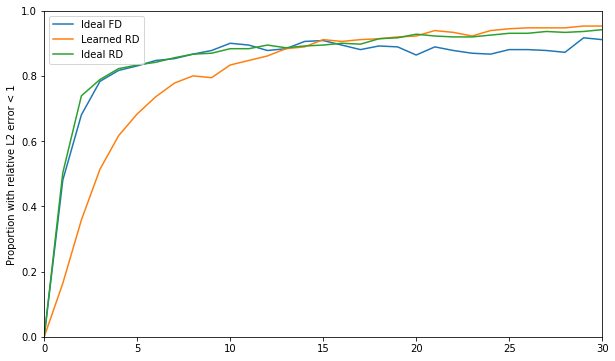

In [22]:
fig,ax1 = plt.subplots(1,1)
ax1.plot(range(60), np.sum(errors_rd[:,0,:]<1,0)/360.)
ax1.plot(range(60), np.sum(errors_rd_true[:,0,:]<1,0)/360.)
ax1.plot(range(60), np.sum(errors_fd_true[:,0,:]<1,0)/360.)

#for idx in range(errors_sp.shape[3]):
#    ax1.plot(range(60), np.sum(errors_sp[:,0,:,idx]<1,0)/360., '--')

ax1.legend({'Learned RD', 'Ideal RD', 'Ideal FD'})

ax1.set_ylim([0, 1])
ax1.set_xlim([0, 30])
ax1.set_ylabel('Proportion with relative L2 error < 1')

plt.savefig('./fig_4b.pdf')

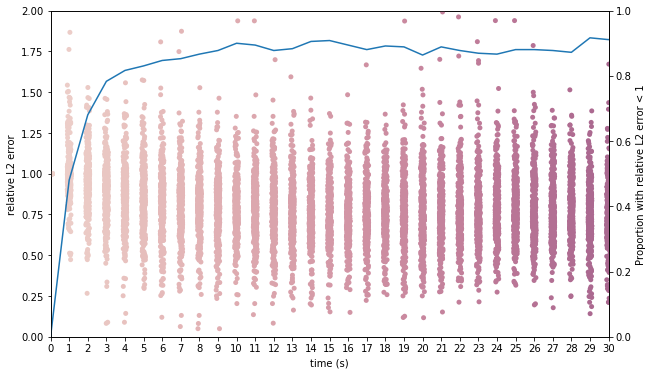

In [9]:
data = pd.DataFrame(errors_rd[:,0,:])
#sns.violinplot(data=data, palette="muted", jitter=True)
ax = sns.stripplot(data=data, palette=sns.cubehelix_palette(60), jitter=True)
ax.set_ylabel("relative L2 error")
ax.set_xlabel('time (s)');
ax.set_ylim([0, 2])
ax1 = ax.twinx()
ax1.plot(range(60), np.sum(errors_rd[:,0,:]<1,0)/360.)
ax1.set_ylim([0, 1])
ax1.set_xlim([0, 30])
ax1.set_ylabel('Proportion with relative L2 error < 1')

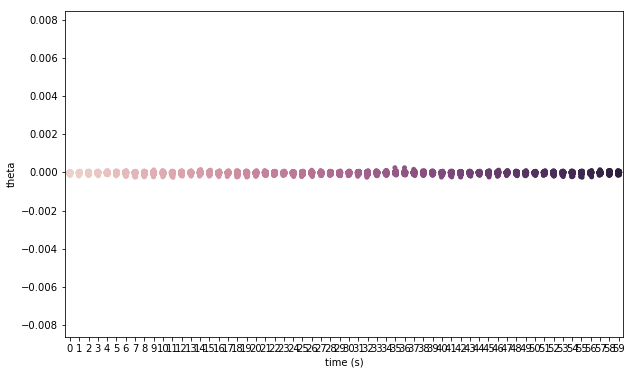

In [218]:
data = pd.DataFrame(angles_rd[:,0,:])
#sns.violinplot(data=data, palette="muted", jitter=True)
ax = sns.stripplot(data=data, palette=sns.cubehelix_palette(60), jitter=True)
ax.set_ylabel("theta")
ax.set_xlabel('time (s)');
#ax.set_ylim([0, 2])
#ax1 = ax.twinx()
#ax1.plot(range(60), np.sum(errors_rd[:,0,:]<1,0)/360.)
#ax1.set_ylim([0, 1])
#ax1.set_xlim([0, 30])
#ax1.set_ylabel('Proportion with relative L2 error < 1')

## Extra. Heatmaps of learnt beta. Not used

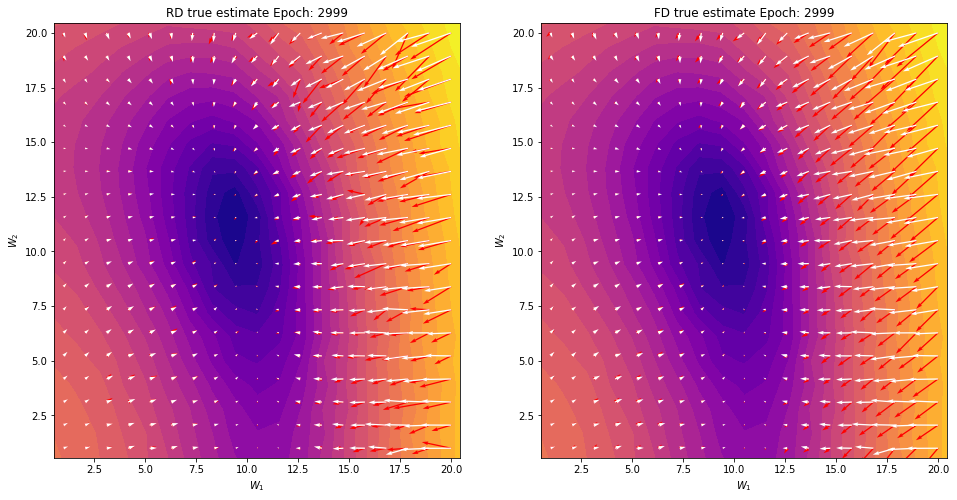

In [80]:
#Plot learning progress over cost function as quiver plots
grad = np.gradient(cost2)
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))
#for ep in range(beta_rd.shape[3]):
ep = 2999

hada = np.multiply
     
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
a=ax1.contourf(np.log(cost2), 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
ax1.quiver(X, Y, -hada(mu2_w2, beta_rd_true[:,:,1,ep]), -hada(mu1_w1, beta_rd_true[:,:,0,ep]), color=(1, 0, 0))
ax1.quiver(X, Y, -grad[1], -grad[0], color=(1, 1, 1))
ax1.set_title("Regression discontinuity")
ax1.set_xlabel('$W_1$')
ax1.set_ylabel('$W_2$')
ax1.set_title('RD true estimate Epoch: %d'%ep)
#fig.colorbar(a);

a=ax2.contourf(np.log(cost2), 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
ax2.quiver(X, Y, -hada(mu2_w2, beta_fd_true[:,:,1,ep]), -hada(mu1_w1, beta_fd_true[:,:,0,ep]), color=(1, 0, 0))
ax2.quiver(X, Y, -grad[1], -grad[0], color=(1, 1, 1))
ax2.set_title("Finite difference")
ax2.set_xlabel('$W_1$')
ax2.set_ylabel('$W_2$')
ax2.set_title('FD true estimate Epoch: %d'%ep)


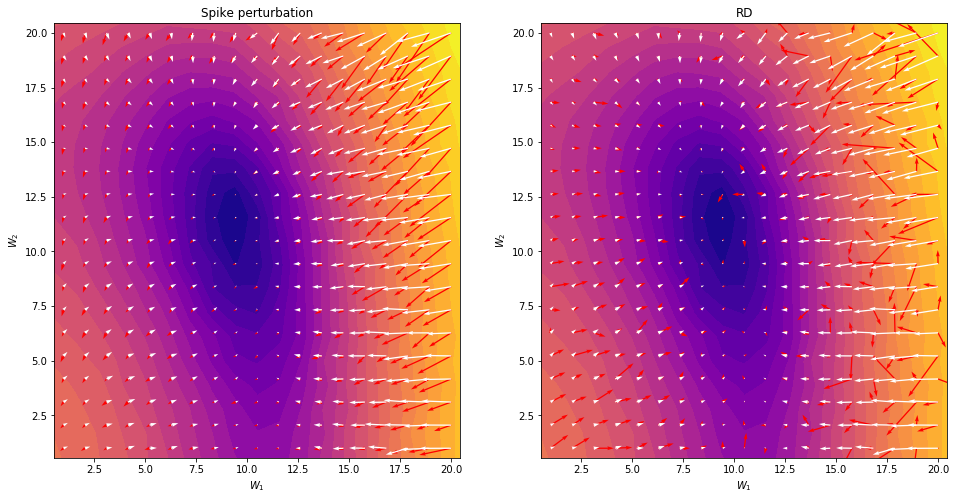

In [79]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
idx = 0
a=ax1.contourf(np.log(cost2), 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
ax1.quiver(X, Y, -hada(mu2_w2, beta_sp[:,:,1,ep,idx]),-hada(mu1_w1, beta_sp[:,:,0,ep,idx]), color=(1, 0, 0))
ax1.quiver(X, Y, -grad[1], -grad[0], color=(1, 1, 1))
ax1.set_title("Spike perturbation")
ax1.set_xlabel('$W_1$')
ax1.set_ylabel('$W_2$')

ep = 999
rn = 1

a=ax2.contourf(np.log(cost2), 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
ax2.quiver(X, Y, -hada(mu2_w2, np.mean(beta_rd_mean[:,:,1,(ep-rn):ep], 2)),-hada(mu1_w1, np.mean(beta_rd_mean[:,:,0,(ep-rn):ep], 2)), color=(1, 0, 0))
ax2.quiver(X, Y, -grad[1], -grad[0], color=(1, 1, 1))
ax2.set_title("RD")
ax2.set_xlabel('$W_1$')
ax2.set_ylabel('$W_2$')

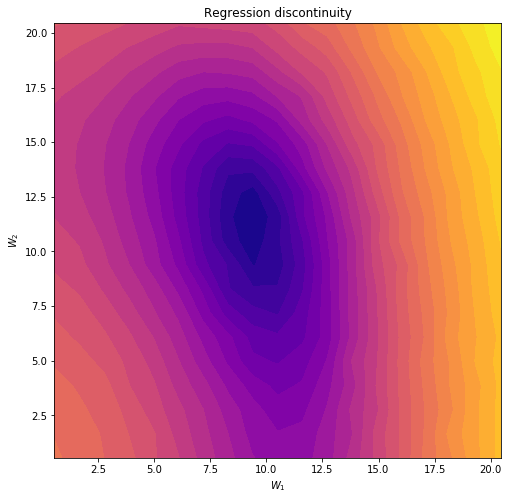

In [81]:
fig, ax1 = plt.subplots(1,1,figsize=(8,8))
grad = np.gradient(cost2)
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))

def init():
    a=ax1.contourf(np.log(cost2), 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
    ax1.set_title("Regression discontinuity")
    ax1.set_xlabel('$W_1$')
    ax1.set_ylabel('$W_2$')
    #fig.colorbar(a);
    return (a,)

def animate(eps):
    rn = 50
    ep = eps*50+rn
    a=ax1.contourf(np.log(cost2), 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
    ax1.quiver(X, Y, -hada(mu2_w2, beta_rd[:,:,1,ep]),-hada(mu1_w1, beta_rd[:,:,0,ep]), color=(1, 0, 0))
    ax1.quiver(X, Y, -grad[1], -grad[0], color=(1, 1, 1))
    ax1.set_title('Epoch: %d'%ep)
    return (None,)        

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=400, blit=False)

In [82]:
rc('animation', html='html5')
matplotlib.rcParams['animation.writer'] = 'avconv'
HTML(anim.to_html5_video())

Make error as a function of epoch

In [28]:
errors_rd = np.zeros((N,N,beta_rd.shape[3]))
for ep in range(beta_rd.shape[3]):
    norm = np.sqrt(grad[0]**2 + grad[1]**2)
    errors_rd[:,:,ep] = np.divide(np.sqrt((beta_rd[:,:,0,ep]-grad[0])**2 + (beta_rd[:,:,1,ep]-grad[1])**2),norm)
errors_rd = errors_rd.reshape((-1,1,beta_rd.shape[3]));

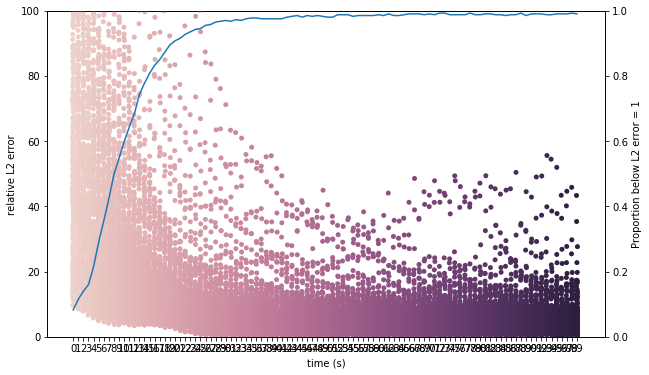

In [37]:
data = pd.DataFrame(errors_rd[:,0,:])
#sns.violinplot(data=data, palette="muted", jitter=True)
ax = sns.stripplot(data=data, palette=sns.cubehelix_palette(100), jitter=True)
ax.set_ylabel("relative L2 error")
ax.set_xlabel('time (s)');
ax.set_ylim([0, 100])
ax1 = ax.twinx()
ax1.plot(range(100), np.sum(errors_rd[:,0,:]<20,0)/400.)
ax1.set_ylim([0, 1])
ax1.set_ylabel('Proportion below L2 error = 1')


Compare to BP estimate, not the numerical cost gradient:

In [6]:
errors_rd = np.zeros((N,N,beta_rd.shape[3]))
for ep in range(beta_rd.shape[3]):
    norm = np.sqrt(beta_rd_true[:,:,0,ep]**2 + beta_rd_true[:,:,1,ep]**2)
    errors_rd[:,:,ep] = np.divide(np.sqrt((beta_rd[:,:,0,ep]-beta_rd_true[:,:,0,ep])**2 + (beta_rd[:,:,1,ep]-beta_rd_true[:,:,1,ep])**2),norm)
errors_rd = errors_rd.reshape((-1,1,beta_rd.shape[3]));

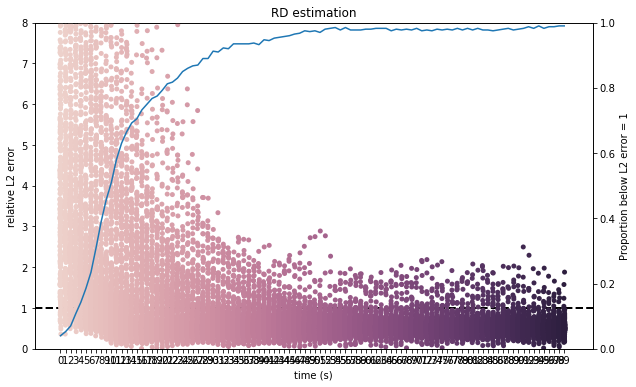

In [8]:
data = pd.DataFrame(errors_rd[:,0,:])
#sns.violinplot(data=data, palette="muted", jitter=True)
#ax = sns.swarmplot(data=data, palette=sns.cubehelix_palette(20))
ax = sns.stripplot(data=data, palette=sns.cubehelix_palette(100), jitter=True)
ax.set_ylabel("relative L2 error")
ax.set_xlabel('time (s)');
ax.set_ylim([0, 8])
ax.axhline(y=1, linestyle='--', color='k', linewidth=2);
ax1 = ax.twinx()
ax1.plot(range(100), np.sum(errors_rd[:,0,:]<1,0)/400.)
ax1.set_ylim([0, 1])
ax1.set_ylabel('Proportion below L2 error = 1')
ax.set_title("RD estimation")

In [25]:
errors_sp = np.zeros((N,N,beta_sp.shape[3],beta_sp.shape[4]))
for ep in range(beta_sp.shape[3]):
    for i in range(beta_sp.shape[4]):
        #norm = np.sqrt(beta_rd_true[:,:,0,ep]**2 + beta_rd_true[:,:,1,ep]**2)
        norm = np.sqrt(grad[0]**2 + grad[1]**2)
        #errors_sp[:,:,ep,i] = np.divide(np.sqrt((beta_sp[:,:,0,ep,i]-beta_rd_true[:,:,0,ep])**2 + (beta_sp[:,:,1,ep,i]-beta_rd_true[:,:,1,ep])**2),norm)
        errors_sp[:,:,ep,i] = np.divide(np.sqrt((beta_sp[:,:,0,ep,i]-grad[0])**2 + (beta_sp[:,:,1,ep,i]-grad[1])**2),norm)
errors_sp = errors_sp.reshape((-1,1,beta_rd.shape[3],beta_sp.shape[4]));

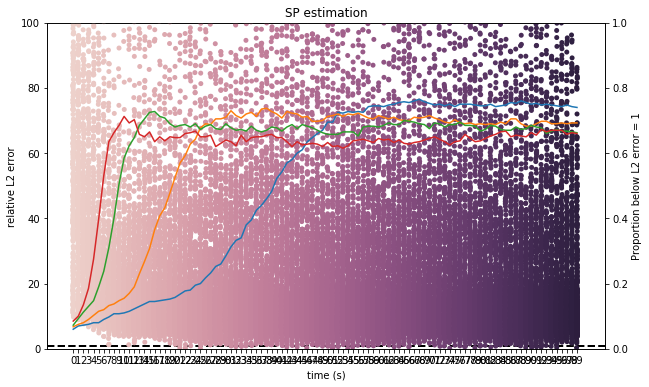

In [33]:
data = pd.DataFrame(errors_sp[:,0,:,3])
#sns.violinplot(data=data, palette="muted", jitter=True)
#ax = sns.swarmplot(data=data, palette=sns.cubehelix_palette(20))
ax = sns.stripplot(data=data, palette=sns.cubehelix_palette(100), jitter=True)
ax.set_ylabel("relative L2 error")
ax.set_xlabel('time (s)');
ax.set_ylim([0, 100])
ax.axhline(y=1, linestyle='--', color='k', linewidth=2);
ax1 = ax.twinx()
ax1.plot(range(100), np.sum(errors_sp[:,0,:]<20,0)/400.)
ax1.set_ylim([0, 1])
ax1.set_ylabel('Proportion below L2 error = 1')
ax.set_title("SP estimation")

In [19]:
errors_sp.shape

(1600, 1, 100)

In [20]:
beta_sp.shape

(20, 20, 2, 100, 4)